### Modelo GEN
Las peliculas se codifican mediante su vector de generos de partida, de tal forma que solo podrá tener ceros y unos. 
lo que dotará al sistema de poca flexibilidad al hacer el producto escalar. En este caso, Los usuarios se codificaran por one hot y las peliculas se codificarán mediante el vector de generos a los que pertenecen

#### Resultados en el modelo 25M
  
    rectificado error en preprocesado 
- Test                         loss: 4.6687
- Test             MAE sobre scores: 1.7454

#### Pendiente:




In [1]:
import pickle
import pandas as pd
from math import pi
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf


#garantizamos mismos resultados entre ejecuciones
import os
os.environ['PYTHONHASHSEED']='0'
rs = 1234  # Semilla aleatoria
np.random.seed(rs)
tf.random.set_seed(rs)

In [2]:
def save_to_pickle(name, item):
    filehandler = open(name+".pkl", "wb")
    pickle.dump(item, filehandler)
    filehandler.close()


def plot_metric(history, metric, valida):
    train_metrics = history.history[metric]
    # if valida:
    #    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    if valida:
        val_metrics = history.history['val_' + metric]
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation ' + metric)
    else:
        plt.title('Training ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    if valida:
        plt.legend(["train_"+metric, 'val_' + metric])
    plt.show()

In [3]:
def crear_modelo(K, LR, num_users, num_pelis, dim_users, dim_pelis, peso_score):
    user_input = tf.keras.layers.Input(shape=(dim_users,), name="input_usr")  # Variable-length sequence of ints
    usuarios_emb = tf.keras.layers.Embedding(input_dim=num_users, output_dim=K, name="embedding_usr")(user_input)
    usuarios = tf.keras.layers.Flatten(name="flatten_usr")(usuarios_emb)  # para pasar de (?,1,K) a (?,K)
    usr_emb_genr = tf.keras.layers.Dense(num_genres, activation='relu', name="usr_dot")(usuarios)  # (?, num_genres)

    pelis_input = tf.keras.layers.Input(shape=(dim_pelis,), name="input_pelis")  # Variable-length sequence of ints
    # pelis_emb = tf.keras.layers.Embedding(input_dim=num_pelis, output_dim=K, name="embedding_pelis")(pelis_input)
    # pelis = tf.keras.layers.Flatten(name="flatten_pelis")(pelis_emb)  # para pasar de (?,1,K) a (?,K)
    # genre_pred = tf.keras.layers.Dense(num_genres, activation='sigmoid', name="genres")(pelis)  # (?, num_genres)

    score_pred = tf.keras.layers.Dot(axes=1, name="scores")([usr_emb_genr, pelis_input])

    model = tf.keras.Model(
        inputs=[user_input, pelis_input],
        outputs=[score_pred],
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        # optimizer=keras.optimizers.RMSprop(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
        # loss_weights=[peso_score, 1 - peso_score],
        metrics=['mean_absolute_error'],  # tf.keras.metrics.BinaryAccuracy()],
    )

    model_usr = tf.keras.Model(
        inputs=[user_input],
        outputs=[usr_emb_genr],
    )

    '''model2.summary()
    output_array2 = model2.predict([valoraciones.user_id, valoraciones.item_id])
    print(output_array2.shape)'''

    return model, model_usr

In [4]:
def entrenar(VALIDATION, K, epochs, batch_size, learning_rate, peso_score, num_users, num_pelis, dim_input_users,
             dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test):
    # SE CREA EL MODELO
    model, mod_usr = crear_modelo(K, learning_rate, num_users, num_pelis, dim_input_users, dim_input_pelis, peso_score)

    # ENTRENAMOS EL MODELO Y EVALUAMOS EN EL CONJUNTO DE TEST
    if VALIDATION:
        # DECLARAMOS UN OBJETO EARLY STOPPING PARA DECIDIR LA MEJOR EPOCH
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        csv_logger = tf.keras.callbacks.CSVLogger("model/model_history_generos_reales_log.csv", append=True)
        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_genREal25_{epoch:06d}.h5', save_best_only=True)
        
        history = model.fit(x=[X_train.user_id, X_train[col_items]], y=[y_train],
                            validation_data=([X_dev.user_id, X_dev[col_items]], [y_dev]),
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stop, checkpoint,csv_logger])
        print('Mejor epoch:', early_stop.stopped_epoch)
        media_en_train = y_train.mean()
    else:
        if epochs == 0:
            epochs = 1000
        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_history_generos_reales2_log.csv')
        csv_logger = tf.keras.callbacks.CSVLogger("model/model_history_generos_reales2_log.csv", append=True)
        history = model.fit(x=[X_train_dev.user_id, X_train_dev[col_items]],
                            y=[y_train_dev],
                            epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])
        media_en_train = y_train_dev.mean()
        usr_emb_g = mod_usr.predict([X_test.user_id])

    losses = model.evaluate([X_test.user_id, X_test[col_items]], [y_test])
    print('\t*-* Test                         loss: %.4f' % losses[0])
    print('\t*-* Test             MAE sobre scores: %.4f' % losses[1])

    prediction = model.predict([X_test.user_id, X_test[col_items]])
    print('Test MAE    modelo: %.4f' % (sum(abs(y_test - prediction.flatten())) / y_test.shape[0]))
    print('Test MAE Sys-Media: %.4f' % (sum(abs(y_test - media_en_train)) / y_test.shape[0]))

    # GRÁFICOS
    plot_metric(history, 'loss', valida=VALIDATION)
    plot_metric(history, 'mean_absolute_error', valida=VALIDATION)

    if VALIDATION:
        return model, early_stop.stopped_epoch
    else:
        return model, prediction, usr_emb_g




In [6]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# MAIN
# ---------------------------------------------------------------------------------------------------------------------

PATH = '/Users/antonio/OneDrive - farmasturias.org/DOCTORADO/paper_generos_peliculas/XAI_movies/cjtos/ml-25M/'
#si cof esta ruta
#PATH = 'c:/Users/antonio.cof/OneDrive - farmasturias.org/DOCTORADO/paper_generos_peliculas/XAI_movies/cjtos/ml-25M/'
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# VALORACIONES
# ---------------------------------------------------------------------------------------------------------------------
#valoraciones = pd.read_csv(PATH+'u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
valoraciones= pd.read_csv(PATH+'ratings.csv',header=1,names=['user_id', 'item_id', 'rating', 'timestamp'])


print(valoraciones)
# quito el timestamp porque no me interesa
valoraciones.drop(['timestamp'], axis='columns', inplace=True)
# de momento dejo el rating como un problema de regresión
print(valoraciones)

num_ejem = valoraciones.shape[0]
num_users = valoraciones.user_id.max()+1  # 943, del 1 al 943. El +1 es porque empieza en 0
num_pelis = valoraciones.item_id.max()+1  # 1682, del 1 al 1682

print('num_users ',num_users)
print('num_pelis ',num_pelis)

          user_id  item_id  rating   timestamp
0               1      306     3.5  1147868817
1               1      307     5.0  1147868828
2               1      665     5.0  1147878820
3               1      899     3.5  1147868510
4               1     1088     4.0  1147868495
...           ...      ...     ...         ...
25000089   162541    50872     4.5  1240953372
25000090   162541    55768     2.5  1240951998
25000091   162541    56176     2.0  1240950697
25000092   162541    58559     4.0  1240953434
25000093   162541    63876     5.0  1240952515

[25000094 rows x 4 columns]
          user_id  item_id  rating
0               1      306     3.5
1               1      307     5.0
2               1      665     5.0
3               1      899     3.5
4               1     1088     4.0
...           ...      ...     ...
25000089   162541    50872     4.5
25000090   162541    55768     2.5
25000091   162541    56176     2.0
25000092   162541    58559     4.0
25000093   162541    6

In [7]:

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ITEMS (PELÍCULAS)
# ---------------------------------------------------------------------------------------------------------------------
#items = pd.read_csv(PATH+'u.item', sep='|', names=['item_id', 'title', 'RD', 'VRD', 'IMDB', 'unknown', 'Action',
#                                                   'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
#                                                   'Documentary', 'Drama', 'Fantasy', 'FilmNoir', 'Horror', 'Musical',
#                                                   'Mystery', 'Romance', 'SciFi', 'Thriller', 'War', 'Western'])
items=pd.read_csv(PATH+'movies_one_hot_genre.csv')
items.drop(['0_(no genres listed)'],axis='columns',inplace=True)
items.drop(['literal'],axis='columns',inplace=True)
print(items)
# de las películas me quedo sólo con los géneros de las mismas. El resto de campos los elimino
# dejo el item_id para comprobaciones
# titles = items.loc[:, ['item_id', 'title']]
items.drop(['RD', 'VRD', 'IMDB', 'unknown'], axis='columns', inplace=True)
print(items)
#num_genres = items.shape[1]-2  # el -2 es para no contar el item_id ni el título. Son 18 géneros
num_genres=19 
print('num_genres',num_genres)
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# PREPARANDO EL CONJUNTO DE DATOS
# ---------------------------------------------------------------------------------------------------------------------
#cjto = valoraciones

# añado las columnas para el item ceros
col_items = items.columns.drop(['item_id', 'title'])
# col_items = col_items.drop(['item_id', 'title'])
#cjto[col_items] = np.zeros((cjto.shape[0], col_items.shape[0]), dtype='int32')

# relleno los items con sus valores
#for i in range(items.shape[0]):
#    num_item = items.iloc[i].item_id
#    if i % 20 == 0:
#        print("item:", num_item)
#    cjto.loc[cjto.item_id == num_item, col_items] = items.iloc[i, 2:].to_list()  # se salta item_id y title

# X / y
#cjto=pd.read_csv('cjto25M.csv',index_col=False)
#X = cjto[['user_id', 'item_id'] + col_items.values.tolist()].copy()
#y = cjto['rating'].copy()

### CARGO LOS DATOS PREPROCESADOS EN SQL 

cjto=pd.read_csv(PATH+'generos_estaticos.csv',index_col=False)
cjto=cjto.rename(columns={'userid':'user_id'})
X=cjto.drop(['rating'],axis='columns')
y = cjto['rating'].copy()

##num_users2 = cjto["userid"].max()+1
##num_pelis2 = cjto.item_id.max()+1  # 1682, del 1 al 1682
num_users=162542
num_pelis=209172
print('num_users ',num_users)
print('num_users2 ',num_users2)
print('num_pelis ',num_pelis)
print('num_pelis2 ',num_pelis2)


TEST = 0.10
DEV = 0.10

# TRAIN/DEV/TEST SPLIT (sin estratificar para prevenir errores)
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, stratify=None, test_size=TEST, random_state=2032)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, stratify=None,
                                                  test_size=DEV, random_state=2032)

print("% test =", TEST, "\n% dev =", DEV)
print("X_train:", X_train.shape)
print("X_dev  :", X_dev.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_dev  :", y_dev.shape)
print("y_test :", y_test.shape)



num_genres 19
num_users  162542


NameError: name 'num_users2' is not defined

In [8]:

TEST = 0.10
DEV = 0.10

# TRAIN/DEV/TEST SPLIT (sin estratificar para prevenir errores)
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, stratify=None, test_size=TEST, random_state=2032)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, stratify=None,
                                                  test_size=DEV, random_state=2032)

print("% test =", TEST, "\n% dev =", DEV)
print("X_train:", X_train.shape)
print("X_dev  :", X_dev.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_dev  :", y_dev.shape)
print("y_test :", y_test.shape)

% test = 0.1 
% dev = 0.1
X_train: (20250076, 21)
X_dev  : (2250009, 21)
X_test : (2500010, 21)
y_train: (20250076,)
y_dev  : (2250009,)
y_test : (2500010,)


In [17]:
items=pd.read_csv(PATH+'movies_one_hot_genre.csv')
items.drop(['0_(no genres listed)'],axis='columns',inplace=True)
items.drop(['literal'],axis='columns',inplace=True)
print(items)
# de las películas me quedo sólo con los géneros de las mismas. El resto de campos los elimino
# dejo el item_id para comprobaciones
# titles = items.loc[:, ['item_id', 'title']]
#items.drop(['RD', 'VRD', 'IMDB', 'unknown'], axis='columns', inplace=True)
print(items)
#num_genres = items.shape[1]-2  # el -2 es para no contar el item_id ni el título. Son 18 géneros
num_genres=19 
print('num_genres',num_genres)
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# PREPARANDO EL CONJUNTO DE DATOS
# ---------------------------------------------------------------------------------------------------------------------
#cjto = valoraciones

# añado las columnas para el item ceros
col_items = items.columns.drop(['item_id', 'title'])
col_items

        item_id  0_Action  0_Adventure  0_Animation  0_Children  0_Comedy  \
0           1.0       0.0          0.0          1.0         1.0       1.0   
1           2.0       0.0          0.0          0.0         1.0       0.0   
2           3.0       0.0          0.0          0.0         0.0       0.0   
3           4.0       0.0          0.0          0.0         0.0       0.0   
4           5.0       0.0          0.0          0.0         0.0       0.0   
...         ...       ...          ...          ...         ...       ...   
62418  209157.0       0.0          0.0          0.0         0.0       0.0   
62419  209159.0       0.0          0.0          0.0         0.0       0.0   
62420  209163.0       0.0          0.0          0.0         0.0       0.0   
62421  209169.0       0.0          0.0          0.0         0.0       0.0   
62422  209171.0       0.0          1.0          0.0         0.0       0.0   

       0_Crime  0_Documentary  0_Drama  0_Fantasy  ...  0_Horror  0_IMAX  \

Index(['0_Action', '0_Adventure', '0_Animation', '0_Children', '0_Comedy',
       '0_Crime', '0_Documentary', '0_Drama', '0_Fantasy', '0_Film-Noir',
       '0_Horror', '0_IMAX', '0_Musical', '0_Mystery', '0_Romance', '0_Sci-Fi',
       '0_Thriller', '0_War', '0_Western'],
      dtype='object')

SON 19 GENEROS 
num_users  162542
num_pelis  209172

In [20]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ENTRENAMIENTO
# ---------------------------------------------------------------------------------------------------------------------
K = 32  # 32
learning_rate = 1e-3
dim_input_users = 1  # el entero a partir del cual se calcula el embedding
dim_input_pelis = 19  # el vector con los géneros de la película (es un genero mas que en el conjunto 100M)
tam_batch = 512
max_epochs = 1000
peso_score = 0.5  # NO SE APLICA

Epoch 1/1000
39551/39551 [==============================] - 481s 12ms/step - loss: 5.1344 - mean_absolute_error: 1.8584 - val_loss: 4.5330 - val_mean_absolute_error: 1.7221
Epoch 2/1000
39551/39551 [==============================] - 483s 12ms/step - loss: 4.4303 - mean_absolute_error: 1.6904 - val_loss: 4.5345 - val_mean_absolute_error: 1.7211
Epoch 3/1000
39551/39551 [==============================] - 498s 13ms/step - loss: 4.3680 - mean_absolute_error: 1.6703 - val_loss: 4.5523 - val_mean_absolute_error: 1.7229
Epoch 4/1000
39551/39551 [==============================] - 490s 12ms/step - loss: 4.3320 - mean_absolute_error: 1.6580 - val_loss: 4.5737 - val_mean_absolute_error: 1.7267
Epoch 5/1000
39551/39551 [==============================] - 508s 13ms/step - loss: 4.3111 - mean_absolute_error: 1.6504 - val_loss: 4.5833 - val_mean_absolute_error: 1.7309
Epoch 6/1000
39551/39551 [==============================] - 476s 12ms/step - loss: 4.2967 - mean_absolute_error: 1.6452 - val_loss: 4.5

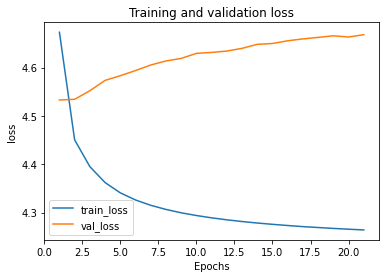

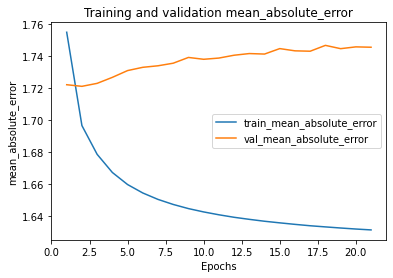

In [21]:


# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN -> DEV Y TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = True
model, n_epochs = entrenar(VALIDATION, K, max_epochs, tam_batch, learning_rate, peso_score, num_users, num_pelis,
                           dim_input_users, dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)



In [ ]:

# ---------
------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN+DEV -> TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = False
model, prediction, usr_emb_genres = entrenar(VALIDATION, K, n_epochs, tam_batch, learning_rate, peso_score, num_users,
                                        num_pelis, dim_input_users, dim_input_pelis,
                                        X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)


# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

print('hiperparámetros: K=%d, batch_size=%d, learning_rate=%f, peso_score=%.2f' % (K, tam_batch, learning_rate,
                                                                                   peso_score))
print("FIN")